In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image

import torch
from torch import nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms

## Image augmentations in pytorch

100%|██████████| 9912422/9912422 [00:00<00:00, 22788566.42it/s]


Extracting /home/gian/data/MNIST/raw/train-images-idx3-ubyte.gz to /home/gian/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 97533.55it/s]


Extracting /home/gian/data/MNIST/raw/train-labels-idx1-ubyte.gz to /home/gian/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3946926.47it/s] 


Extracting /home/gian/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/gian/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17412.68it/s]

Extracting /home/gian/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/gian/data/MNIST/raw

img type: <class 'PIL.Image.Image'>, target type: <class 'int'>


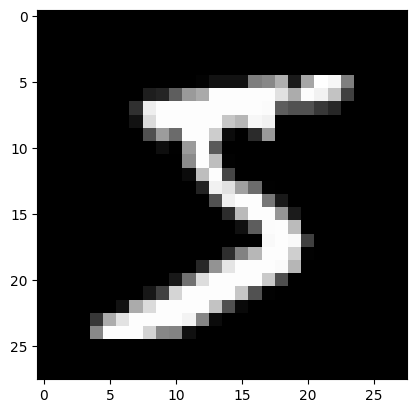

In [2]:
# Previously, we used a custom class to extract images as numpy arrays,
# but torch's vision package uses PIL (Pillow) Images as a common image format.
# PIL Image: https://pillow.readthedocs.io/en/stable/reference/Image.html

data = torchvision.datasets.MNIST('~/data', train=True, download=True)
img, target = data[0]
print(f'img type: {type(img)}, target type: {type(target)}')

# conversion PIL -> numpy & numpy -> PIL
img_np = np.array(img)  # convert PIL Image to numpy
img_pil = Image.fromarray(img_np)  # convert numpy array to PIL Image

plt.imshow(img_pil, cmap='gray')  # matplotlib understands both types

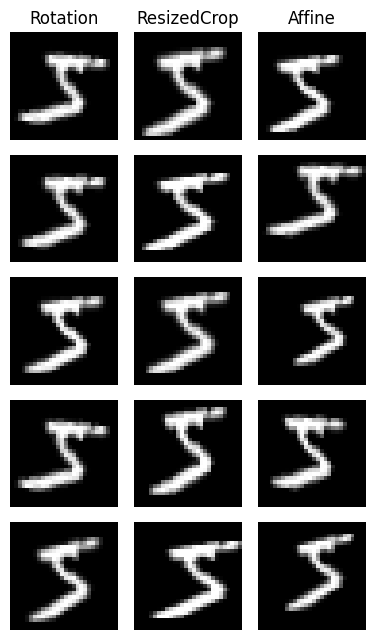

In [3]:
# torchvision has a set of transformations, including augmentations, for PIL Images

augmentations = [
    ('Rotation', transforms.RandomRotation(degrees=15, interpolation=transforms.InterpolationMode.BILINEAR)),
    ('ResizedCrop', transforms.RandomResizedCrop(28, scale=(0.8, 1.0))),
    ('Affine', transforms.RandomAffine(degrees=15, translate=(.1, .1),
                                       scale=(0.8, 1.2), shear=(-15, 15),
                                       interpolation=transforms.InterpolationMode.BILINEAR)),
]

n = 5
fig, axs = plt.subplots(n, len(augmentations), figsize=(len(augmentations) * 1.3, n * 1.3))

for (name, aug), axs_col in zip(augmentations, axs.T):
    axs_col[0].set_title(name)
    for ax in axs_col:
        ax.imshow(aug(img), cmap='gray')
        ax.axis('off')
plt.tight_layout()

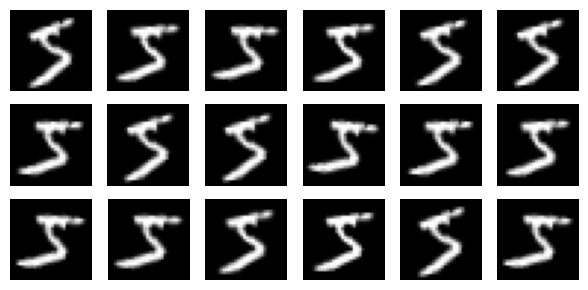

In [4]:
# You can pass a transform to the dataset
data_aug = torchvision.datasets.MNIST('~/data', train=True, transform=augmentations[0][1])
rows, cols = 3, 6
fig, axs = plt.subplots(rows, cols, figsize=(cols, rows))

# the transforms will be applied 'live' every time it is loaded
for ax in axs.reshape(-1):
    ax.imshow(data_aug[0][0], cmap='gray')
    ax.axis('off')
plt.tight_layout()

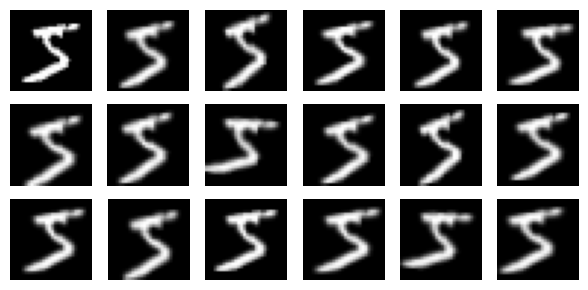

In [5]:
# compose transforms
transform = transforms.Compose([
    transforms.RandomRotation(degrees=15, interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
])
data_aug = torchvision.datasets.MNIST('~/data', train=True, transform=transform)

rows, cols = 3, 6
fig, axs = plt.subplots(rows, cols, figsize=(cols, rows))
for ax in axs.reshape(-1):
    ax.imshow(data_aug[0][0], cmap='gray')
    ax.axis('off')
axs[0, 0].imshow(img, cmap='gray')
plt.tight_layout()

mean: 0.1306604871562883, std: 0.30810780244715075
img type: <class 'torch.Tensor'>


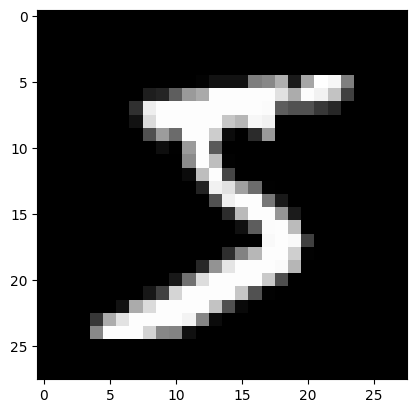

In [6]:
# convert to tensor and normalize
# to normalize, let's find the mean and std from the dataset
mnist_mean = torch.mean(data.data.float()).item() / 255
mnist_std = torch.std(data.data.float()).item() / 255
print(f'mean: {mnist_mean}, std: {mnist_std}')

# from PIL Image to tensor (C, H, W) with values from 0 to 1
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

data = torchvision.datasets.MNIST('~/data', train=True, transform=transform)
img, target = data[0]
print(f'img type: {type(img)}')

# we can then denormalize for visualization:
img_denormed = img.numpy()[0] * mnist_std + mnist_mean
plt.imshow(img_denormed, cmap='gray')

## Now lets load data for todays challenge

In [7]:
transform_normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mnist_mean, std=mnist_std)
])

loader_kwargs = {'batch_size': 100, 'num_workers': 2}

# last 1000 training images for validation
data_valid = torchvision.datasets.MNIST('~/data', train=True, transform=transform_normalize)
data_valid.data = data_valid.data[1000:2000]
data_valid.targets = data_valid.targets[1000:2000]

# all images in the test set
data_test = torchvision.datasets.MNIST('~/data', train=False, transform=transform_normalize)

loader_valid = torch.utils.data.DataLoader(data_valid, **loader_kwargs)
loader_test = torch.utils.data.DataLoader(data_test, **loader_kwargs)

def get_train_loader(augmentations):
    transform_train = transforms.Compose([*augmentations, transform_normalize])
    # first 1000 training images for training
    data_train = torchvision.datasets.MNIST('~/data', train=True, transform=transform_train)
    data_train.data = data_train.data[:1000]
    data_train.targets = data_train.targets[:1000]
    loader_train = torch.utils.data.DataLoader(data_train, **loader_kwargs, shuffle=True)
    return loader_train

## You can use the following helper functions for training and visualization

In [8]:
def one_epoch(model, data_loader, opt=None):
    device = next(model.parameters()).device
    train = False if opt is None else True
    model.train() if train else model.eval()
    losses, correct, total = [], 0, 0
    for x, y in data_loader:
        x, y = x.to(device), y.to(device)
        with torch.set_grad_enabled(train):
            logits = model(x)
        loss = F.cross_entropy(logits, y)

        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()

        losses.append(loss.item())
        total += len(x)
        correct += (torch.argmax(logits, dim=1) == y).sum().item()
    return np.mean(losses), correct / total


def train(model, loader_train, loader_valid, lr=1e-3, max_epochs=200, weight_decay=0., patience=20):
    train_losses, train_accuracies = [], []
    valid_losses, valid_accuracies = [], []

    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    best_valid_accuracy = 0
    best_valid_accuracy_epoch = 0

    t = tqdm(range(max_epochs))
    for epoch in t:
        train_loss, train_acc = one_epoch(model, loader_train, opt)
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        valid_loss, valid_acc = one_epoch(model, loader_valid)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_acc)

        t.set_description(f'train_acc: {train_acc:.2f}, valid_acc: {valid_acc:.2f}')

        if valid_acc > best_valid_accuracy:
            best_valid_accuracy = valid_acc
            best_valid_accuracy_epoch = epoch

        if epoch > best_valid_accuracy_epoch + patience:
            break
    t.set_description(f'best valid acc: {best_valid_accuracy:.2f}')

    return train_losses, train_accuracies, valid_losses, valid_accuracies

In [9]:
def plot_history(train_losses, train_accuracies, valid_losses, valid_accuracies):
    plt.figure(figsize=(7, 3))

    plt.subplot(1, 2, 1)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    p = plt.plot(train_losses, label='train')
    plt.plot(valid_losses, label='valid')
    plt.ylim(0, 2)
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    p = plt.plot(train_accuracies, label='train')
    plt.plot(valid_accuracies, label='valid')
    plt.ylim(0, 1.05)
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

# Challenge

Using only 1000 examples of the MNIST training dataset,  
see if you can improve the baseline performance with regularization methods, including:
* weight decay (L2 regularization)
* dropout
* data (image) augmentations

Finally, evaluate your best model on the test set

*Bonus:*  
What performance can you achieve using the whole dataset?

In [10]:
# TODO: extend this to allow dropout

def build_mlp(n_hidden=512):
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(28 * 28, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, 10),
    )

In [11]:
##### solution
# (this is just one way to add dropout to the model)
def build_mlp(n_hidden=512, p_dropout=0.):
    return nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.2 if p_dropout > 0 else 0),
        nn.Linear(28 * 28, n_hidden),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Dropout(p_dropout),
        nn.Linear(n_hidden, 10),
    )
#####

In [12]:
# baseline with 1000 training images
loader_train = get_train_loader(augmentations=[])
model = build_mlp()
plot_history(*train(model, loader_train, loader_valid))

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

weight_decay: 0.1


  0%|          | 0/200 [00:00<?, ?it/s]

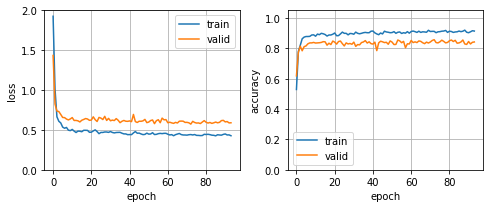

weight_decay: 0.01


  0%|          | 0/200 [00:00<?, ?it/s]

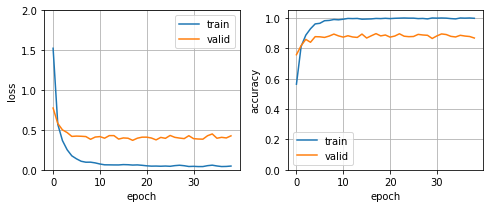

weight_decay: 0.001


  0%|          | 0/200 [00:00<?, ?it/s]

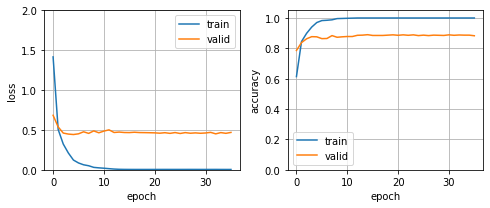

weight_decay: 0.0001


  0%|          | 0/200 [00:00<?, ?it/s]

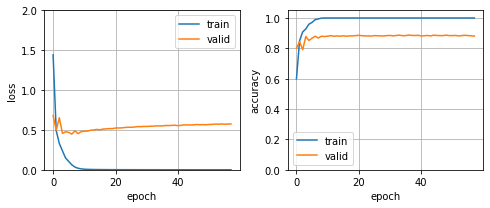

In [ ]:
# weight decay
loader_train = get_train_loader([])
for weight_decay in 1e-1, 1e-2, 1e-3, 1e-4:
    print('weight_decay:', weight_decay)
    model = build_mlp()
    plot_history(*train(model, loader_train, loader_valid, weight_decay=weight_decay))

p_dropout: 0.3


  0%|          | 0/200 [00:00<?, ?it/s]

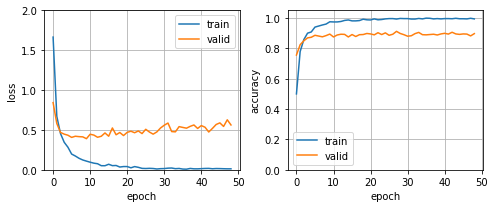

p_dropout: 0.5


  0%|          | 0/200 [00:00<?, ?it/s]

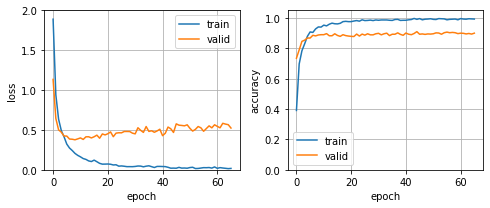

p_dropout: 0.7


  0%|          | 0/200 [00:00<?, ?it/s]

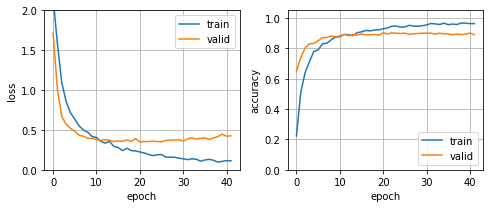

p_dropout: 0.9


  0%|          | 0/200 [00:00<?, ?it/s]

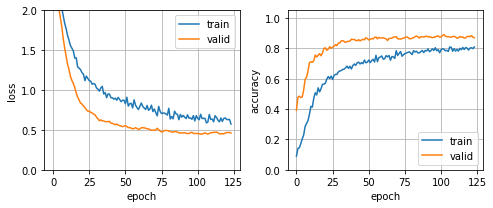

In [ ]:
# dropout
loader_train = get_train_loader([])
for p_dropout in 0.3, 0.5, 0.7, 0.9:
    print('p_dropout:', p_dropout)
    model = build_mlp(p_dropout=p_dropout)
    plot_history(*train(model, loader_train, loader_valid))

Rotation


  0%|          | 0/200 [00:00<?, ?it/s]

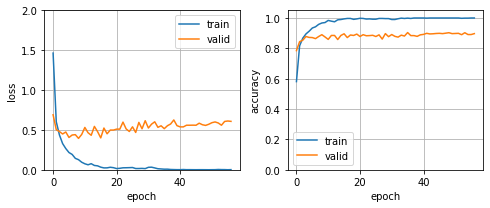

ResizedCrop


  0%|          | 0/200 [00:00<?, ?it/s]

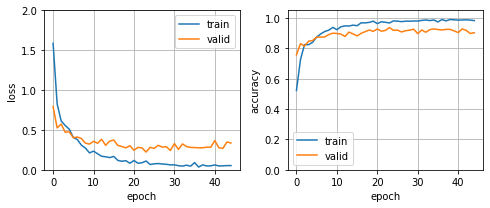

Affine


  0%|          | 0/200 [00:00<?, ?it/s]

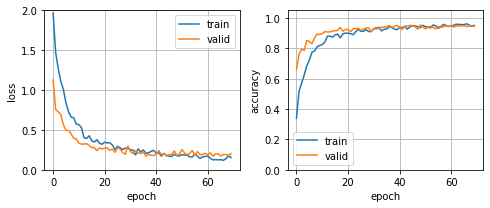

In [ ]:
# augmentations
for name, augmentation in augmentations:
    print(name)
    model = build_mlp()
    plot_history(*train(model, get_train_loader([augmentation]), loader_valid))

  0%|          | 0/200 [00:00<?, ?it/s]

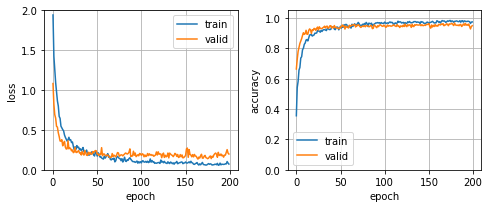

  0%|          | 0/200 [00:00<?, ?it/s]

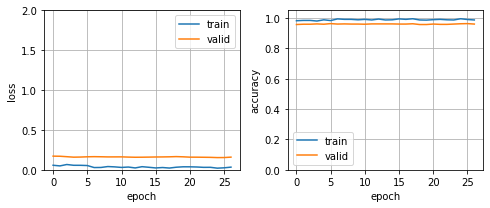

In [ ]:
# Let's try training a bit longer with one of the most promising regularization
loader_train = get_train_loader([augmentations[-1][1]])
model = build_mlp()
plot_history(*train(model, loader_train, loader_valid, patience=200))
plot_history(*train(model, loader_train, loader_valid, lr=1e-4))

Image augmentations took us from 89 % to 96 % on the validation set.  
Less than half the amount of errors.

Let's get an unbiased estimate of how well it performs, by evaluating our model on the test set:

In [ ]:
one_epoch(model, loader_test)[1]

0.9657

## Bonus:

  0%|          | 0/200 [00:00<?, ?it/s]

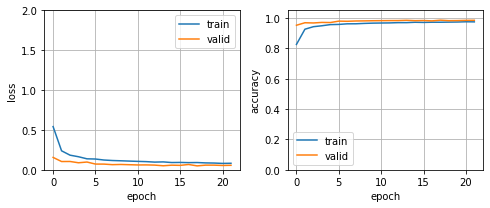

In [ ]:
transform_train = transforms.Compose([augmentations[-1][1], transform_normalize])
data_train = torchvision.datasets.MNIST('~/data', train=True, transform=transform_train)
data_train.data = data_train.data[:45000]
data_train.targets = data_train.targets[:45000]
loader_train = torch.utils.data.DataLoader(data_train, **loader_kwargs, shuffle=True)

data_valid = torchvision.datasets.MNIST('~/data', train=True, transform=transform_normalize)
data_valid.data = data_valid.data[45000:]
data_valid.targets = data_valid.targets[45000:]
loader_valid_ = torch.utils.data.DataLoader(data_valid, **loader_kwargs)

model = build_mlp()
plot_history(*train(model, loader_train, loader_valid_, patience=3))

  0%|          | 0/200 [00:00<?, ?it/s]

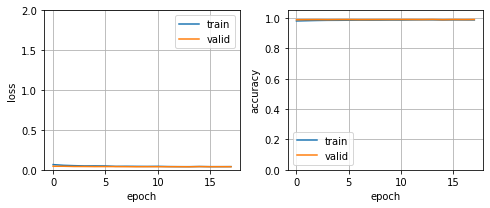

In [ ]:
plot_history(*train(model, loader_train, loader_valid_, patience=3, lr=1e-4))

In [ ]:
one_epoch(model, loader_test)[1]

0.9904